In [1]:
# !pip install download -i https://pypi.tuna.tsinghua.edu.cn/simple

In [1]:
from download import download

# url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

# download(url, "./datasets-cifar10-bin", kind="tar.gz", replace=True)

In [5]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype

batch_size = 32  # Batch size
image_size = 128  # Image size of training data
workers = 2  # Number of parallel workers
num_classes = 1000  # Number of classes


def create_dataset(data_set, usage, resize, batch_size, workers):

    trans = []

    trans += [
        vision.Resize((128, 128)),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)

    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    data_set = data_set.batch(batch_size)
    return data_set

In [6]:
import mindspore
from mindspore.dataset import vision, transforms
import mindspore.dataset as ds

trainset = ds.ImageFolderDataset("./imagenet2012/train", decode=True)
testset = ds.ImageFolderDataset("./imagenet2012/val", decode=True)

dataset_train = create_dataset(trainset,
                               usage="train",
                               resize=image_size,
                               batch_size=batch_size,
                               workers=workers)

dataset_val = create_dataset(testset,
                                 usage="test",
                                 resize=image_size,
                                 batch_size=batch_size,
                                 workers=workers)

step_size_val = dataset_val.get_dataset_size()
step_size_train = dataset_train.get_dataset_size()

In [7]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

print(f"Labels: {labels[:6]}")

Image shape: (32, 3, 128, 128), Label shape: (32,)
Labels: [503 380 532 621 791 485]


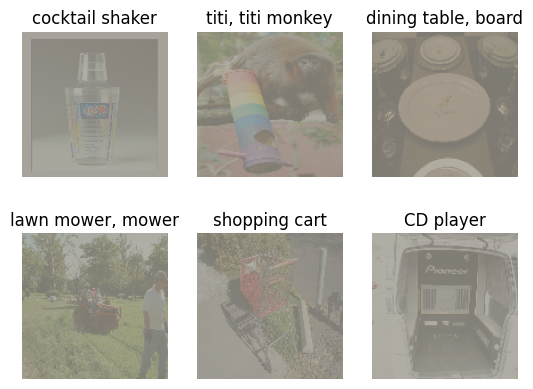

In [8]:
classes = []

with open('./imagenet2012/imagenet-classes.txt', "r") as f:
    for line in f:
        line = line.rstrip()
        if line:
            classes.append(line)

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

In [23]:
images.shape

(32, 3, 128, 128)

In [9]:
from typing import Type, Union, List, Optional
import mindspore.nn as nn
from mindspore.common.initializer import Normal

# Initialize the parameters of the convolutional layer and BatchNorm layer
weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # The number of convolution kernels at the last layer is the same as that of convolution kernels at the first layer.

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcut

        out = self.conv1(x)  # First layer of the main body: 3 x 3 convolutional layer
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # Second layer of the main body: 3 x 3 convolutional layer
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # output the sum of the main body and the shortcuts
        out = self.relu(out)

        return out

In [10]:
class ResidualBlock(nn.Cell):
    expansion = 4  # The number of convolution kernels at the last layer is four times that of convolution kernels at the first layer.

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortcut

        out = self.conv1(x)  # First layer of the main body: 1 x 1 convolutional layer
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # Second layer of the main body: 3 x 3 convolutional layer
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # Third layer of the main body: 1 x 1 convolutional layer
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # The output is the sum of the main body and the shortcut.
        out = self.relu(out)

        return out

In [11]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # Stack residual networks.
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)


In [12]:
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # At the first convolutional layer, the number of the input channels is 3 (color image) and that of the output channels is 64.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # Maximum pooling layer, reducing the image size
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # Define each residual network structure block
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # average pooling layer
        self.avg_pool = nn.AvgPool2d()
        # flattern layer
        self.flatten = nn.Flatten()
        # fully-connected layer
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


In [13]:
def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrained_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # load pre-trained models
        download(url=model_url, path=pretrained_ckpt, replace=True)
        param_dict = load_checkpoint(pretrained_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50 model"
    resnet50_url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)


In [21]:
in_channel

2048

In [19]:
# Define the ResNet50 network.
network = resnet50(pretrained=True)

# Size of the input layer of the fully-connected layer
in_channel = network.fc.in_channels
fc = nn.Dense(in_channels=in_channel, out_channels=1000)
# Reset the fully-connected layer.
network.fc = fc



file_sizes: 100%|█████████████████████████████| 102M/102M [00:00<00:00, 124MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt


In [20]:
# Set the learning rate
num_epochs = 5
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# Define optimizer and loss function
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss


In [16]:
import os

# Creating Iterators
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# Optimal model storage path
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)


In [17]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """Model taining"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        if i % 100 == 0 or i == step_size_train - 1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]' %
                  (epoch + 1, num_epochs, i + 1, step_size_train, loss))
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """Model Evaluation"""
    network.set_train(False)

    correct_num = 0.0  # Number of correct predictions
    total_num = 0.0  # Total number of predictions

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # Prediction results
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # Accuracy

    return acc


In [18]:
# Start training loop
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, curr_loss, curr_acc
    ))
    print("-" * 50)

    # Save the model that has achieved the highest prediction accuracy
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)


Start Training Loop ...


ValueError: For 'MatMul' the input dimensions must be equal, but got 'x1_col': 32768 and 'x2_row': 2048.

----------------------------------------------------
- C++ Call Stack: (For framework developers)
----------------------------------------------------
mindspore/core/ops/mat_mul.cc:101 InferShape
